In [1]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 3_Basic regression_Predict fuel efficiency

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic Auto MPG dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras tutorials and guides to learn more.)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.16.1


#### The Auto MPG dataset
The dataset is available from the UCI Machine Learning Repository.

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Clean the data
The dataset contains a few unknown values:

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [7]:
dataset = dataset.dropna()

The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values in the column with pd.get_dummies.

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


#### Split the data into training and test sets
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [10]:
#this is one way to do it, another way would be to use the train_test_split from sklearn
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
'''
from sklearn.model_selection import train_test_split
X = dataset.drop(['MPG'], axis=1)
y = dataset['MPG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

'''


"\nfrom sklearn.model_selection import train_test_split\nX = dataset.drop(['MPG'], axis=1)\ny = dataset['MPG']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n"

#### Inspect the data
Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

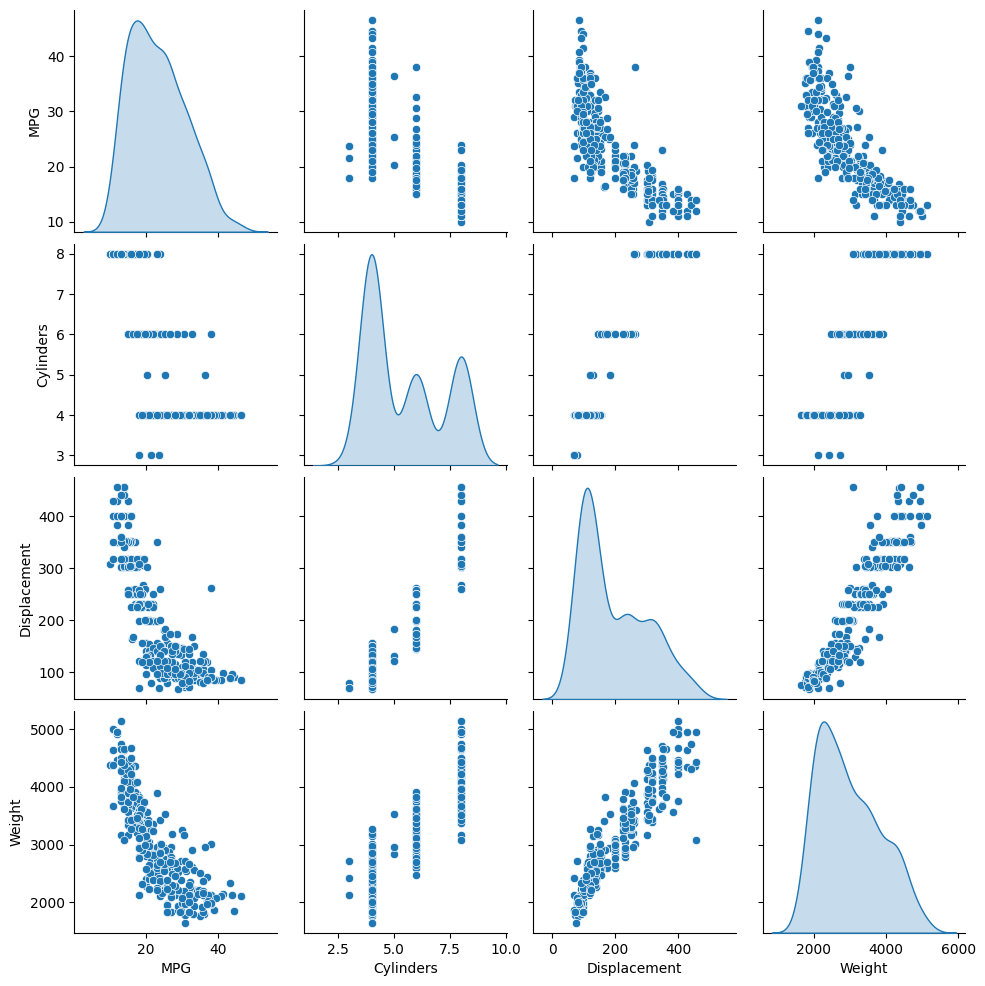

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


#### Split features from labels
Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

#### Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

#### The Normalization layer
The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.


In [16]:
normalizer = tf.keras.layers.Normalization(axis=-1) #create layer
normalizer.adapt(np.array(train_features)) #fit layer to the data
print(normalizer.mean.numpy())

[[5.4777069e+00 1.9531847e+02 1.0486943e+02 2.9902517e+03 1.5559236e+01
  7.5898087e+01 1.7834395e-01 1.9745223e-01 6.2420380e-01]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[4 90.0 75.0 2125.0 14.5 74 False False True]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


#### Linear regression
Before building a deep neural network model, start with linear regression using one and several variables.

#### Linear regression with one variable
Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

- Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
- Apply a linear transformation (y=mx+b) to produce 1 output using a linear layer (tf.keras.layers.Dense).
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the 'Horsepower' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:

In [18]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

C:\Users\ih371\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

This model will predict 'MPG' from 'Horsepower'.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of (10, 1):

In [20]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[-0.89618695],
       [-0.50614166],
       [ 1.6541091 ],
       [-1.2562287 ],
       [-1.1362147 ],
       [-0.4461347 ],
       [-1.3462392 ],
       [-1.1362147 ],
       [-0.2961173 ],
       [-0.50614166]], dtype=float32)

Once the model is built, configure the training procedure using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).

In [21]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras Model.fit to execute the training for 100 epochs:

In [22]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 1.05 s
Wall time: 4.55 s


Visualize the model's training progress using the stats stored in the history object:

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.790471,4.188557,95
96,3.789913,4.200472,96
97,3.798717,4.205278,97
98,3.813779,4.203382,98
99,3.796553,4.186120,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

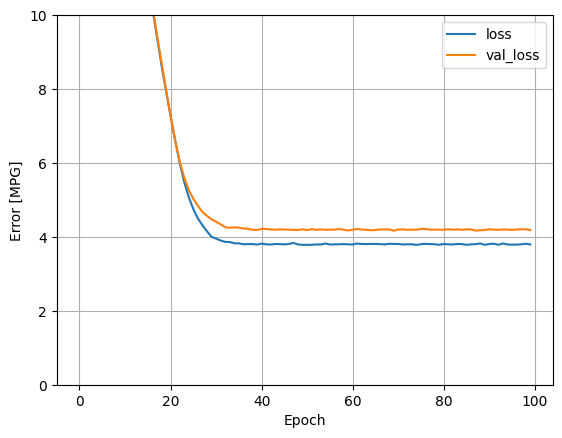

In [25]:
plot_loss(history)

Collect the results on the test set for later:

In [26]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [27]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [28]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

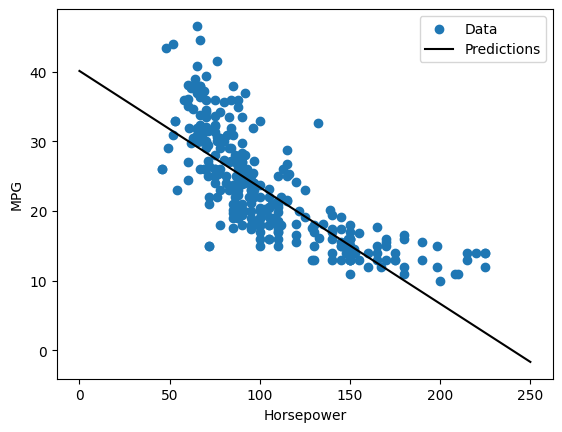

In [29]:
plot_horsepower(x, y)

#### Linear regression with multiple inputs
You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same y=mx+b
 except that 
 is a matrix and 
 is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [33]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call Model.predict on a batch of inputs, it produces units=1 outputs for each example:

In [34]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


array([[ 1.1475285 ],
       [ 0.56338644],
       [-1.6119531 ],
       [ 1.6238015 ],
       [-0.15681708],
       [-0.6688217 ],
       [-0.27457762],
       [ 0.65656275],
       [-0.6260357 ],
       [-0.8830014 ]], dtype=float32)

When you call the model, its weight matrices will be built—check that the kernel weights (the 
 in 
) have a shape of (9, 1):

In [35]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_1/dense_1/kernel>

Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

In [36]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [37]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 672 ms
Wall time: 4.62 s


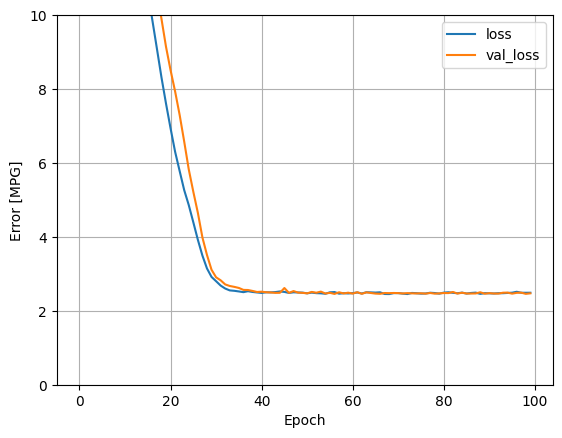

In [38]:
plot_loss(history)

In [39]:
#Collect the results on the test set for later:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

#### Regression with a deep neural network (DNN)
In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

- The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model).
- Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
- A linear Dense single-output layer.

Both models will use the same training procedure, so the compile method is included in the build_and_compile_model function below.

In [54]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#### Regression using a DNN and a single input
Create a DNN model with only 'Horsepower' as input and horsepower_normalizer (defined earlier) as the normalization layer:

In [55]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [56]:
dnn_horsepower_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [57]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 422 ms
Wall time: 5.18 s


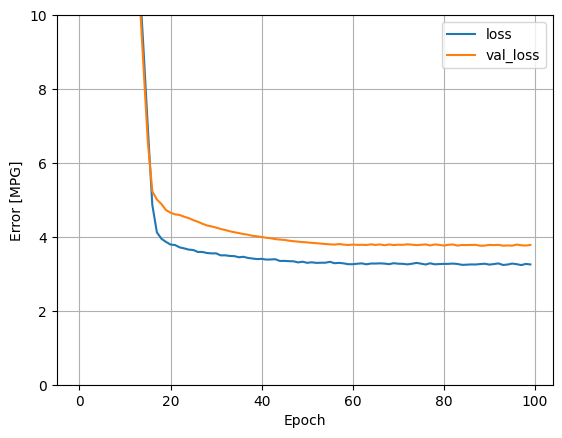

In [58]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [59]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000226BAB867A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


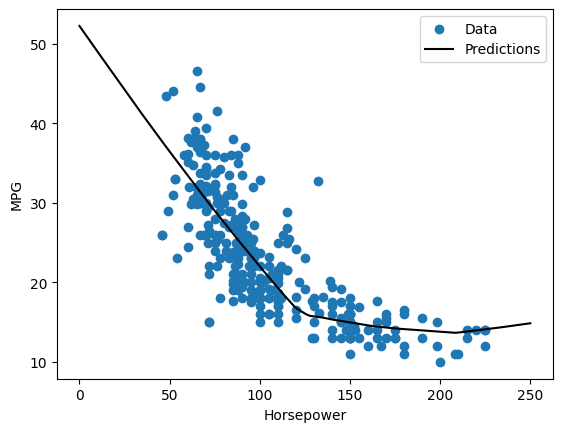

In [60]:
plot_horsepower(x, y)

In [61]:
#Collect the results on the test set for later:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

#### Regression using a DNN and multiple inputs
Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [62]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [63]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 531 ms
Wall time: 5.31 s


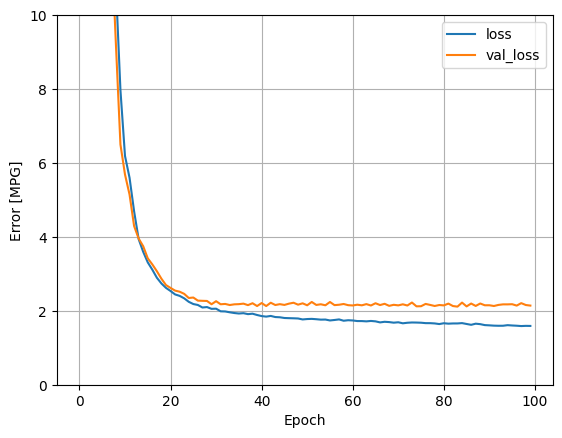

In [64]:
plot_loss(history)

In [65]:
#Collect the results on the test set:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

#### Performance
Since all models have been trained, you can review their test set performance:

In [66]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.808031
linear_model,2.501869
dnn_horsepower_model,3.030039
dnn_model,1.722614


#### Make predictions
You can now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


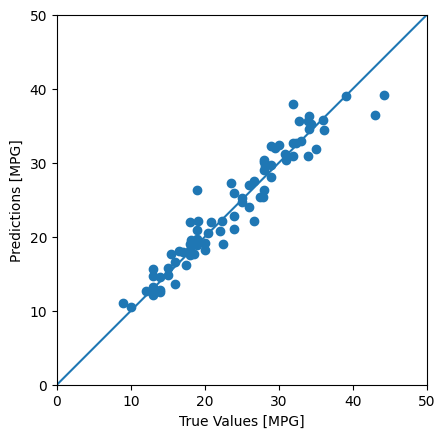

In [67]:
test_predictions = dnn_model.predict(test_features).flatten() #Input test dataset features

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions) #plot against predictions and actual labels
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [101]:
test_features.iloc[0,:]

Cylinders            8
Displacement     390.0
Horsepower       190.0
Weight          3850.0
Acceleration       8.5
Model Year          70
Europe           False
Japan            False
USA               True
Name: 9, dtype: object

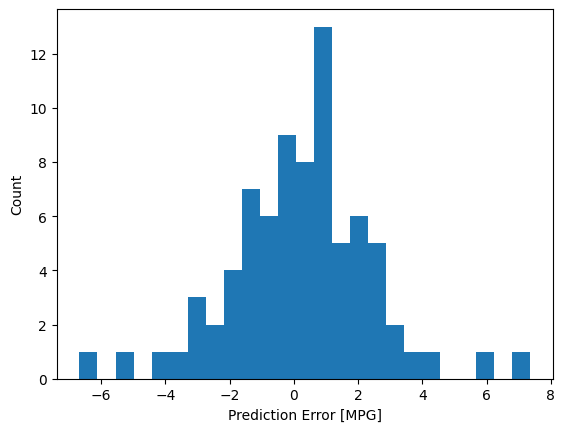

In [68]:
#Error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [69]:
#If you're happy with the model, save it for later use with Model.save:
dnn_model.save('dnn_model.keras')

In [70]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [71]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.808031
linear_model,2.501869
dnn_horsepower_model,3.030039
dnn_model,1.722614
reloaded,1.722614


It gives identical output.

#### Conclusion
This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (tf.keras.losses.MeanSquaredError) and mean absolute error (MAE) (tf.keras.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.